In [144]:
# import standard python packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# import scikit-learn packages
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# import the statcast package
from pybaseball import statcast

In [145]:
# import warnings
# warnings.filterwarnings('ignore')

In [146]:
%run PitchUseAndPerformanceFitRegressionModels.ipynb

In [147]:
# load statcast dataset and store in pitches_2021 DataFrame
# first day of season was April 1, 2021
# last day of season was October 3, 2021
# pitches_2021 = statcast(start_dt="2021-04-01", end_dt="2021-10-03")

# pitches_2021.head()

# pitches_2021.to_csv('statcast_search_all_2021.csv', index=False)

In [148]:
# load statcast dataset and store in pitches_2022 DataFrame
# first day of season was April 7, 2022
# last day of season was October 5, 2022
# pitches_2022 = statcast(start_dt="2022-04-07", end_dt="2022-10-05")

# pitches_2022.head()

# pitches_2022.to_csv('statcast_search_all_2022.csv', index=False)

In [149]:
# load statcast dataset and store in pitches_2023 DataFrame
# first day of season was March 30, 2023
# last day of season was October 1, 2023
# pitches_2023 = statcast(start_dt="2023-03-30", end_dt="2023-10-01")

# pitches_2023.head()

# pitches_2023.to_csv('statcast_search_all_2023.csv', index=False)

In [150]:
pitches_2021 = pd.read_csv('statcast_search_all_2021.csv')

In [151]:
pitches_2022 = pd.read_csv('statcast_search_all_2022.csv')

In [152]:
pitches_2023 = pd.read_csv('statcast_search_all_2023.csv')

In [153]:
pitches = pd.concat([pitches_2023, pitches_2022], axis=0, ignore_index=True)
pitches = pd.concat([pitches, pitches_2021], axis=0, ignore_index=True)
pitches.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
0,CH,2023-10-01,89.0,-2.80,5.59,"Robertson, Nick",677008,687798,field_out,hit_into_play,...,1,1,6,Infield shade,Standard,250.0,0.0,-0.090,NaN,NaN
1,FF,2023-10-01,96.9,-2.40,5.90,"Robertson, Nick",677008,687798,NaN,foul,...,1,1,6,Infield shade,Standard,211.0,0.0,0.000,NaN,NaN
2,CH,2023-10-01,90.0,-2.93,5.56,"Robertson, Nick",677008,687798,NaN,ball,...,1,1,6,Infield shade,Standard,250.0,0.0,0.016,NaN,NaN
3,ST,2023-10-01,82.2,-3.09,5.55,"Robertson, Nick",677008,687798,NaN,ball,...,1,1,6,Infield shade,Standard,58.0,0.0,0.009,NaN,NaN
4,CH,2023-10-01,89.2,-2.87,5.58,"Robertson, Nick",677008,687798,NaN,swinging_strike,...,1,1,6,Infield shade,Standard,257.0,0.0,-0.023,NaN,NaN


In [154]:
pitches = pitches[pd.isna(pitches['delta_run_exp']) == False]
pitches = pitches[(pitches['balls'] <= 3) & (pitches['strikes'] <= 2)]
len(pitches.index)

2136200

In [155]:
# number of pitches of each pitch type in dataset
pitches.groupby(['pitch_type', 'pitch_name']).size().sort_values(ascending=False)

pitch_type  pitch_name     
FF          4-Seam Fastball    717478
SL          Slider             370260
SI          Sinker             327985
CH          Changeup           237658
FC          Cutter             157259
CU          Curveball          155407
ST          Sweeper             70634
KC          Knuckle Curve       46566
FS          Split-Finger        38608
SV          Slurve               7490
FA          Other                3237
EP          Eephus               1171
FO          Forkball              778
CS          Slow Curve            305
KN          Knuckleball           278
SC          Screwball              75
PO          Pitch Out               1
dtype: int64

In [156]:
# replace forkball with split-finger
pitches = pitches.replace('FO', 'FS')
pitches = pitches.replace('Forkball', 'Split-Finger')

In [157]:
pitches = pitches[pitches['pitch_type'].isin(['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST', 'SV'])]
len(pitches.index)

2130123

In [158]:
for pitch_type in ['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST', 'SV']:
    pitches[pitch_type] = pitches['pitch_type'] == pitch_type
    pitches[pitch_type] = pitches[pitch_type].astype(int)

In [159]:
# Creating Sample Numbers

In [160]:
# sort dataset by date of game, game id, plate appearance of game, then the pitch number of the plate appearance
pitches = pitches.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'], ignore_index=True)

pitches.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,CH,CU,FC,FF,FS,KC,SI,SL,ST,SV
0,FF,2021-04-01,95.1,-1.95,6.11,"Márquez, Germán",605141,608566,NaN,ball,...,0,0,0,1,0,0,0,0,0,0
1,FF,2021-04-01,95.6,-2.04,6.03,"Márquez, Germán",605141,608566,NaN,foul,...,0,0,0,1,0,0,0,0,0,0
2,FF,2021-04-01,96.1,-1.76,6.27,"Márquez, Germán",605141,608566,NaN,ball,...,0,0,0,1,0,0,0,0,0,0
3,FF,2021-04-01,95.4,-1.69,6.17,"Márquez, Germán",605141,608566,NaN,ball,...,0,0,0,1,0,0,0,0,0,0
4,FF,2021-04-01,95.9,-1.92,6.15,"Márquez, Germán",605141,608566,NaN,called_strike,...,0,0,0,1,0,0,0,0,0,0


In [161]:
# create column containing season pitch count
# .cumcount() starts at 0, add 1 to start count at 1
pitches['season_pitch_number'] = pitches.groupby(['game_year', 'player_name', 'pitcher']).cumcount() + 1

In [162]:
# create DataFrame holding number of pitches thrown in season by pitcher
# number of pitches thrown is equivalent to the maximum of the season pitch count
pitcher_seasons = pitches.groupby(['game_year', 'player_name', 'pitcher']).agg({'season_pitch_number': 'max'})

# view the first 10 pitchers' season pitch counts
pitcher_seasons.head(10)

season_pitch_number
game_year player_name      pitcher                     
2021      Abad, Fernando   472551                   299
          Abbott, Cory     676265                   352
          Abreu, Albert    656061                   642
          Abreu, Bryan     650556                   689
          Acevedo, Domingo 642758                   174
          Adam, Jason      592094                   218
          Adams, Austin    613534                   962
          Adon, Joan       672851                    94
          Aguilar, Miguel  620396                   104
          Akin, Keegan     669211                  1768

In [163]:
# initialize the sample size
sample_size = 1000

# add column for the number of samples of the sample size for each player
# use // for integer division, round to lowest whole number
pitcher_seasons['num_samples'] = pitcher_seasons['season_pitch_number'] // sample_size

# subset columns to keep only player_name, pitcher, num_samples
# player_name, pitcher are indexed and are kept by default
pitcher_seasons = pitcher_seasons[['num_samples']]

pitcher_seasons.head()

num_samples
game_year player_name      pitcher             
2021      Abad, Fernando   472551             0
          Abbott, Cory     676265             0
          Abreu, Albert    656061             0
          Abreu, Bryan     650556             0
          Acevedo, Domingo 642758             0

In [164]:
# pitches = pitches.loc[:, pitches.columns != 'num_samples']

In [165]:
# add column containing number of samples of sample size to pitches DataFrame
# use inner join as all pitchers have a number of samples
pitches = pitches.join(pitcher_seasons, on=['game_year', 'player_name', 'pitcher'], how='inner')

# view DataFrame with number of samples
pitches[['game_date', 'game_year', 'player_name', 'batter', 'pitcher', 'home_team', 'game_pk', 'season_pitch_number', 'num_samples']].head()

,game_date,game_year,player_name,batter,pitcher,home_team,game_pk,season_pitch_number,num_samples
0,2021-04-01,2021,"Márquez, Germán",605141,608566,COL,634615,1,2
1,2021-04-01,2021,"Márquez, Germán",605141,608566,COL,634615,2,2
2,2021-04-01,2021,"Márquez, Germán",605141,608566,COL,634615,3,2
3,2021-04-01,2021,"Márquez, Germán",605141,608566,COL,634615,4,2
4,2021-04-01,2021,"Márquez, Germán",605141,608566,COL,634615,5,2


In [166]:
# create a DataFrame filtered only for pitchers who have at least one sample of 1150 pitches
# this removes pitchers who have thrown less than 1150 pitches
pitches_min_1000 = pitches[pitches['num_samples'] > 0]
# filter to have only pitches in a sample
pitches_min_1000 = pitches_min_1000[pitches_min_1000['season_pitch_number'] <= (pitches_min_1000['num_samples'] * sample_size)]

# view number of pitches that were thrown in filtered dataset
pitches_min_1000.groupby(['game_year', 'player_name', 'pitcher']).agg({'season_pitch_number': 'max'}).head()

season_pitch_number
game_year player_name      pitcher                     
2021      Akin, Keegan     669211                  1000
          Alcantara, Sandy 645261                  3000
          Alexander, Tyler 641302                  1000
          Allard, Kolby    663465                  2000
          Alvarado, José   621237                  1000

In [167]:
# view max number of pitches that were thrown in filtered dataset
# sort highest-to-lowest by filtered pitch count, then alphabetically by name
pitches_min_1000.groupby(['game_year', 'player_name', 'pitcher']).agg({'season_pitch_number': 'max'}).sort_values(by=['season_pitch_number', 'player_name', 'pitcher'], ascending=[False, True, True]).head()

season_pitch_number
game_year player_name      pitcher                     
2021      Alcantara, Sandy 645261                  3000
2022      Alcantara, Sandy 645261                  3000
2023      Bassitt, Chris   605135                  3000
2021      Berríos, José    621244                  3000
          Buehler, Walker  621111                  3000

In [168]:
# cast num_samples to int
# must be int to group
pitches_min_1000['num_samples'] = pitches_min_1000['num_samples'].apply(np.int64)

# create sample number for each pitch
# assign all pitches to sample 1 first
pitches_min_1000['sample_number'] = 1
# if season_pitch_number is greater than 1000 then assign to sample 2
# there will be no pitches above 3000
# this is there are no pitchers with more than three samples of 1000 pitches
pitches_min_1000.loc[(pitches_min_1000['season_pitch_number'] > 1000) & (pitches_min_1000['season_pitch_number'] <= 2000), 'sample_number'] = 2
# if season_pitch_number is greater than 1000 then assign to sample 2
# there will be no pitches above 3000
# this is there are no pitchers with more than three samples of 1000 pitches
pitches_min_1000.loc[(pitches_min_1000['season_pitch_number'] > 2000), 'sample_number'] = 3

# view first 10 pitches with sample number
pitches_min_1000[['game_date', 'game_year', 'player_name', 'batter', 'pitcher', 'home_team', 'game_pk', 'season_pitch_number', 'num_samples', 'sample_number']].head(10)

,game_date,game_year,player_name,batter,pitcher,home_team,game_pk,season_pitch_number,num_samples,sample_number
0,2021-04-01,2021,"Márquez, Germán",605141,608566,COL,634615,1,2,1
1,2021-04-01,2021,"Márquez, Germán",605141,608566,COL,634615,2,2,1
2,2021-04-01,2021,"Márquez, Germán",605141,608566,COL,634615,3,2,1
3,2021-04-01,2021,"Márquez, Germán",605141,608566,COL,634615,4,2,1
4,2021-04-01,2021,"Márquez, Germán",605141,608566,COL,634615,5,2,1
5,2021-04-01,2021,"Márquez, Germán",605141,608566,COL,634615,6,2,1
6,2021-04-01,2021,"Márquez, Germán",608369,608566,COL,634615,7,2,1
7,2021-04-01,2021,"Márquez, Germán",457759,608566,COL,634615,8,2,1
8,2021-04-01,2021,"Márquez, Germán",457759,608566,COL,634615,9,2,1
9,2021-04-01,2021,"Márquez, Germán",457759,608566,COL,634615,10,2,1


# Percentage Thrown in Full Season

In [169]:
# create DataFrame containing the name of the pitcher and percentage thrown of each pitch
pitch_pct_full_season = pitches.groupby(['game_year', 'player_name', 'pitcher'])[['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST', 'SV']].agg(CH=('CH', 'mean'),
                                                                                                                                                   CU=('CU', 'mean'),
                                                                                                                                                   FC=('FC', 'mean'),
                                                                                                                                                   FF=('FF', 'mean'),
                                                                                                                                                   FS=('FS', 'mean'),
                                                                                                                                                   KC=('KC', 'mean'),
                                                                                                                                                   SI=('SI', 'mean'),
                                                                                                                                                   SL=('SL', 'mean'),
                                                                                                                                                   ST=('ST', 'mean'),
                                                                                                                                                   SV=('SV', 'mean'))

# view percentage thrown of each pitch
# round percentages to three decimals
pitch_pct_full_season.round({'CH': 3, 'CU': 3, 'FC': 3, 'FF': 3, 'FS': 3, 'KC': 3, 'SI': 3, 'SL': 3, 'ST': 3, 'SV': 3}).head()

CH     CU     FC     FF   FS     KC  \
game_year player_name      pitcher                                           
2021      Abad, Fernando   472551   0.157  0.000  0.054  0.064  0.0  0.261   
          Abbott, Cory     676265   0.062  0.168  0.000  0.591  0.0  0.000   
          Abreu, Albert    656061   0.159  0.002  0.000  0.164  0.0  0.000   
          Abreu, Bryan     650556   0.000  0.174  0.000  0.433  0.0  0.000   
          Acevedo, Domingo 642758   0.207  0.000  0.000  0.500  0.0  0.000   

                                       SI     SL   ST   SV  
game_year player_name      pitcher                          
2021      Abad, Fernando   472551   0.465  0.000  0.0  0.0  
          Abbott, Cory     676265   0.000  0.179  0.0  0.0  
          Abreu, Albert    656061   0.327  0.349  0.0  0.0  
          Abreu, Bryan     650556   0.020  0.373  0.0  0.0  
          Acevedo, Domingo 642758   0.006  0.287  0.0  0.0

In [170]:
# flatten to add 'pitch_type' as an index
pitch_pct_full_season = pitch_pct_full_season.stack()
# change column name to 'pct'
pitch_pct_full_season = pitch_pct_full_season.to_frame().rename(columns={0: 'pct'})
# change index names to 'player_name', 'pitcher' and 'pitch_type'
pitch_pct_full_season = pitch_pct_full_season.rename_axis(['game_year', 'player_name', 'pitcher', 'pitch_type'])

# filter to remove pitch types not thrown
pitch_pct_full_season = pitch_pct_full_season[pitch_pct_full_season['pct'] >= 0.001]

# view percentage thrown of each pitch
# round percentages to three decimals
pitch_pct_full_season.round({'pct': 3}).head()

pct
game_year player_name    pitcher pitch_type       
2021      Abad, Fernando 472551  CH          0.157
                                 FC          0.054
                                 FF          0.064
                                 KC          0.261
                                 SI          0.465

In [171]:
# create MultiIndex with name of each pitcher, pitch, and rank of the pitch thrown in their mix
# method set to 'min' to ensure pitches with same percentage thrown will have the lowest rank
# ascending set to False to rank from highest percentage thrown to lowest percentage thrown
pitch_rank_full_season = pitch_pct_full_season.groupby(['game_year', 'player_name', 'pitcher']).rank(method='min', ascending=False)
# convert decimal rank to integer
pitch_rank_full_season['pct'] = pitch_rank_full_season['pct'].apply(np.int64)
# change column name to 'use'
pitch_rank_full_season = pitch_rank_full_season.rename(columns={'pct': 'use'})

# view use rank of each pitch
pitch_rank_full_season.head()

use
game_year player_name    pitcher pitch_type     
2021      Abad, Fernando 472551  CH            3
                                 FC            5
                                 FF            4
                                 KC            2
                                 SI            1

In [172]:
# view summary statistics of MultiIndex
pitch_rank_full_season.describe()

,use
count,10373.000000
mean,2.715029
std,1.411403
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,8.000000


In [173]:
# convert use column to string representations of rank
pitch_rank_full_season['use'] = pitch_rank_full_season['use'].replace({1: 'first', 2: 'second', 3: 'third', 4: 'fourth', 5: 'fifth', 6: 'sixth', 7: 'seventh', 8: 'eighth', 9: 'ninth'})

# view use rank of each pitch
pitch_rank_full_season.head()

use
game_year player_name    pitcher pitch_type        
2021      Abad, Fernando 472551  CH           third
                                 FC           fifth
                                 FF          fourth
                                 KC          second
                                 SI           first

In [174]:
# create Series with name of each pitcher and number of pitch types thrown
num_pitch_types = pitch_pct_full_season.groupby(['game_year', 'player_name', 'pitcher']).size()

# filter to remove pitchers who threw exactly one pitch type
two_or_more_pitch_types = num_pitch_types[num_pitch_types > 1]
# change column name to 'num_pitch_types'
two_or_more_pitch_types = two_or_more_pitch_types.to_frame().rename(columns={0: 'num_pitch_types'})

# number of pitches who threw more than one pitch type
len(two_or_more_pitch_types.index)

2478

In [175]:
# merge pitch_rank_full_season MultiIndex with two_or_more_pitches DataFrame
# how set to 'inner' to filter for pitchers who threw more than one pitch type
pitch_rank_full_season = pitch_rank_full_season.join(two_or_more_pitch_types, how='inner')

# subset columns to keep only 'use'
# will remove 'num_pitches' column
pitch_rank_full_season = pitch_rank_full_season[['use']]

# view use rank of pitchers who threw more than one pitch type
pitch_rank_full_season.head()

use
game_year player_name    pitcher pitch_type        
2021      Abad, Fernando 472551  CH           third
                                 FC           fifth
                                 FF          fourth
                                 KC          second
                                 SI           first

In [176]:
# merge pitch_pct_full_season MultiIndex and pitch_rank_full_season MultiIndex
# how set to 'inner' to filter out pitchers who threw exactly one pitch type
pitch_pct_full_season = pitch_pct_full_season.join(pitch_rank_full_season, how='inner')

# view pitcher, pitch type, percent thrown and use rank
pitch_pct_full_season.head(20)

pct     use
game_year player_name      pitcher pitch_type                  
2021      Abad, Fernando   472551  CH          0.157191   third
                                   FC          0.053512   fifth
                                   FF          0.063545  fourth
                                   KC          0.260870  second
                                   SI          0.464883   first
          Abbott, Cory     676265  CH          0.062500  fourth
                                   CU          0.167614   third
                                   FF          0.590909   first
                                   SL          0.178977  second
          Abreu, Albert    656061  CH          0.158879  fourth
                                   CU          0.001558   fifth
                                   FF          0.163551   third
                                   SI          0.327103  second
                                   SL          0.348910   first
          Abreu, Bryan     650556  CU          0.174165   third
                                   FF          0.432511   first
                                   SI          0.020319  fourth
                                   SL          0.373004  second
          Acevedo, Domingo 642758  CH          0.206897   third
                                   FF          0.500000   first

In [177]:
# Percentage Thrown in Sample

In [178]:
# create MultiIndex containing the name of the pitcher, the sample and percentage thrown of each pitch
pitch_pct_sample = pitches_min_1000.groupby(['game_year', 'player_name', 'pitcher', 'sample_number'])[['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST', 'SV']].agg(CH=('CH', 'mean'),
                                                                                                                                                           CU=('CU', 'mean'),
                                                                                                                                                           FC=('FC', 'mean'),
                                                                                                                                                           FF=('FF', 'mean'),
                                                                                                                                                           FS=('FS', 'mean'),
                                                                                                                                                           KC=('KC', 'mean'),
                                                                                                                                                           SI=('SI', 'mean'),
                                                                                                                                                           SL=('SL', 'mean'),
                                                                                                                                                           ST=('ST', 'mean'),
                                                                                                                                                           SV=('SV', 'mean'))

# view percentage thrown in each sample
# round percentages to three decimals
pitch_pct_sample.round({'CH': 3, 'CU': 3, 'FC': 3, 'FF': 3, 'FS': 3, 'KC': 3, 'SI': 3, 'SL': 3, 'ST': 3, 'SV': 3}).head()

CH     CU     FC     FF  \
game_year player_name      pitcher sample_number                               
2021      Akin, Keegan     669211  1              0.191  0.047  0.000  0.582   
          Alcantara, Sandy 645261  1              0.277  0.049  0.000  0.235   
                                   2              0.241  0.030  0.000  0.150   
                                   3              0.195  0.000  0.000  0.254   
          Alexander, Tyler 641302  1              0.172  0.000  0.385  0.172   

                                                   FS   KC     SI     SL   ST  \
game_year player_name      pitcher sample_number                                
2021      Akin, Keegan     669211  1              0.0  0.0  0.000  0.180  0.0   
          Alcantara, Sandy 645261  1              0.0  0.0  0.247  0.192  0.0   
                                   2              0.0  0.0  0.361  0.218  0.0   
                                   3              0.0  0.0  0.238  0.313  0.0   
          Alexander, Tyler 641302  1              0.0  0.0  0.182  0.089  0.0   

                                                   SV  
game_year player_name      pitcher sample_number       
2021      Akin, Keegan     669211  1              0.0  
          Alcantara, Sandy 645261  1              0.0  
                                   2              0.0  
                                   3              0.0  
          Alexander, Tyler 641302  1              0.0

In [179]:
# flatten to add 'pitch_type' as an index
pitch_pct_sample = pitch_pct_sample.stack()
# change column name to 'pct'
pitch_pct_sample = pitch_pct_sample.to_frame().rename(columns={0: 'pct'})
# change index names to 'player_name', 'pitcher', 'sample_number', and 'pitch_type'
pitch_pct_sample = pitch_pct_sample.rename_axis(['game_year', 'player_name', 'pitcher', 'sample_number', 'pitch_type'])

# filter to remove pitch types not thrown
pitch_pct_sample = pitch_pct_sample[pitch_pct_sample['pct'] >= 0.001]

# view percentage thrown of each pitch
# round percentages to three decimals
pitch_pct_sample.round({'pct': 3}).head()

pct
game_year player_name      pitcher sample_number pitch_type       
2021      Akin, Keegan     669211  1             CH          0.191
                                                 CU          0.047
                                                 FF          0.582
                                                 SL          0.180
          Alcantara, Sandy 645261  1             CH          0.277

# Run Value in Full Season

In [180]:
rv_full_season = pitches.groupby(['game_year', 'player_name', 'pitcher', 'pitch_type']).agg(num_pitches=('delta_run_exp', 'count'),
                                                                                            RV=('delta_run_exp', 'sum'))
rv_full_season['RV_per_100'] = (-1) * ((rv_full_season['RV'] / rv_full_season['num_pitches']) * 100)
rv_full_season = rv_full_season[['RV_per_100']]
rv_full_season.round({'RV_per_100': 3}).head()

RV_per_100
game_year player_name    pitcher pitch_type            
2021      Abad, Fernando 472551  CH               1.860
                                 FC              -6.031
                                 FF             -14.668
                                 KC              -1.183
                                 SI               2.145

In [181]:
rv_sample = pitches_min_1000.groupby(['game_year', 'player_name', 'pitcher', 'sample_number', 'pitch_type']).agg(num_pitches=('delta_run_exp', 'count'),
                                                                                                                 RV=('delta_run_exp', 'sum'))
rv_sample['RV_per_100'] = (-1) * ((rv_sample['RV'] / rv_sample['num_pitches']) * 100)
rv_sample = rv_sample[['RV_per_100']]
rv_sample.round({'RV_per_100': 3}).head()

RV_per_100
game_year player_name      pitcher sample_number pitch_type            
2021      Akin, Keegan     669211  1             CH              -2.548
                                                 CU              -6.777
                                                 FF               0.664
                                                 SL              -4.340
          Alcantara, Sandy 645261  1             CH               2.573

# Samples

In [182]:
# create MultiIndex by joining woba_sample and pitch_use_sample
samples = rv_sample.join(pitch_pct_sample, how='inner')

# rename wOBA and percent thrown columns with '_sample' as a suffix
samples = samples.rename(columns={'RV_per_100': 'RV_per_100_sample', 'pct': 'pct_sample'})

# merge woba_full_season to add wOBA of pitch type in full season
samples = samples.join(rv_full_season, how='inner')

# merge pitch_pct_full_season to give percent thrown of pitch type in full season
samples = samples.join(pitch_pct_full_season, how='inner')

# rename wOBA and percent thrown columns with '_full_season' as a suffix
samples = samples.rename(columns={'RV_per_100': 'RV_per_100_full_season', 'pct': 'pct_full_season'})

# samples = samples[(samples['wOBA_sample'].isna() == False) & (samples['wOBA_full_season'].isna() == False)]

# view descriptive stats of DataFrame
samples.describe()

,RV_per_100_sample,pct_sample,RV_per_100_full_season,pct_full_season
count,5317.000000,5317.000000,5317.000000,5317.000000
mean,-0.199892,0.213644,-0.239572,0.213307
std,3.582518,0.157360,2.747589,0.155032
min,-86.400000,0.001000,-56.960000,0.001017
25%,-1.268182,0.089000,-1.074719,0.088647
50%,0.097414,0.185000,0.022067,0.185259
75%,1.350862,0.307000,1.017308,0.305398
max,32.850000,0.792000,17.340000,0.788023


In [183]:
samples[samples['pct_full_season'] >= 0.08].describe()

,RV_per_100_sample,pct_sample,RV_per_100_full_season,pct_full_season
count,4102.000000,4102.000000,4102.000000,4102.000000
mean,0.097049,0.265749,0.063839,0.265342
std,1.794008,0.141297,1.396075,0.138298
min,-8.803846,0.001000,-8.797191,0.080016
25%,-0.945797,0.154000,-0.783975,0.154999
50%,0.195489,0.235000,0.124640,0.235057
75%,1.290129,0.349000,1.019229,0.348378
max,8.125000,0.792000,4.779184,0.788023


In [184]:
# calculate difference in wOBA of pitch type for the sample
samples['RV_per_100_diff'] = samples['RV_per_100_sample'] - samples['RV_per_100_full_season']
# calculate percent difference in percentage change of pitch type for the sample
samples['pct_diff'] = samples['pct_sample'] - samples['pct_full_season']

# view dataset
# round all decimal values to three places
samples.round({'RV_per_100_sample': 3, 'pct_sample': 3, 'RV_per_100_full_season': 3, 'pct_full_season': 3, 'pct_diff': 3}).head()

RV_per_100_sample  \
game_year player_name      pitcher pitch_type sample_number                      
2021      Akin, Keegan     669211  CH         1                         -2.548   
                                   CU         1                         -6.777   
                                   FF         1                          0.664   
                                   SL         1                         -4.340   
          Alcantara, Sandy 645261  CH         1                          2.573   

                                                             pct_sample  \
game_year player_name      pitcher pitch_type sample_number               
2021      Akin, Keegan     669211  CH         1                   0.191   
                                   CU         1                   0.047   
                                   FF         1                   0.582   
                                   SL         1                   0.180   
          Alcantara, Sandy 645261  CH         1                   0.277   

                                                             RV_per_100_full_season  \
game_year player_name      pitcher pitch_type sample_number                           
2021      Akin, Keegan     669211  CH         1                              -2.646   
                                   CU         1                              -4.045   
                                   FF         1                               0.660   
                                   SL         1                              -3.508   
          Alcantara, Sandy 645261  CH         1                               0.596   

                                                             pct_full_season  \
game_year player_name      pitcher pitch_type sample_number                    
2021      Akin, Keegan     669211  CH         1                        0.195   
                                   CU         1                        0.037   
                                   FF         1                        0.572   
                                   SL         1                        0.196   
          Alcantara, Sandy 645261  CH         1                        0.236   

                                                                use  \
game_year player_name      pitcher pitch_type sample_number           
2021      Akin, Keegan     669211  CH         1               third   
                                   CU         1              fourth   
                                   FF         1               first   
                                   SL         1              second   
          Alcantara, Sandy 645261  CH         1               third   

                                                             RV_per_100_diff  \
game_year player_name      pitcher pitch_type sample_number                    
2021      Akin, Keegan     669211  CH         1                     0.097472   
                                   CU         1                    -2.731141   
                                   FF         1                     0.004518   
                                   SL         1                    -0.832219   
          Alcantara, Sandy 645261  CH         1                     1.977314   

                                                             pct_diff  
game_year player_name      pitcher pitch_type sample_number            
2021      Akin, Keegan     669211  CH         1                -0.004  
                                   CU         1                 0.010  
                                   FF         1                 0.010  
                                   SL         1                -0.016  
          Alcantara, Sandy 645261  CH         1                 0.041

In [185]:
samples[samples['RV_per_100_full_season'] == 0]

,,,,,RV_per_100_sample,pct_sample,RV_per_100_full_season,pct_full_season,use,RV_per_100_diff,pct_diff
game_year,player_name,pitcher,pitch_type,sample_number,,,,,,,
2021,"Fulmer, Michael",605242,ST,1,-0.0,0.002,-0.0,0.001691,sixth,0.0,0.000309


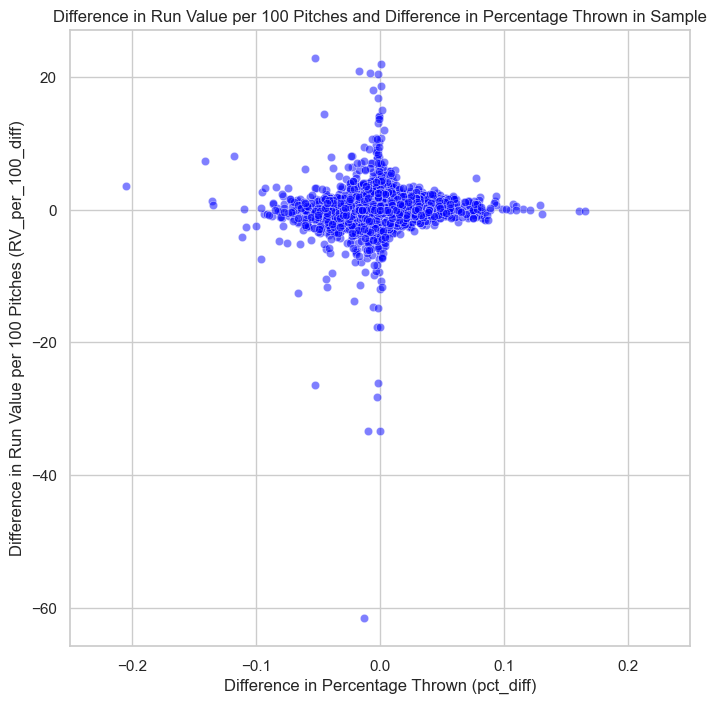

In [186]:
# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# set the figure size to 8x8
f, ax = plt.subplots(figsize=(8, 8))
# plot percentage difference and wOBA difference as scatterplot
# set point color to blue
# set transperancy to 0.5
sns.scatterplot(x='pct_diff', y='RV_per_100_diff', color='blue', alpha=0.5, data=samples, ax=ax);

# set x-axis limit from -0.25 to 0.25
ax.set_xlim(left=-0.25, right=0.25);
# set y-axis limit from -0.75 to 1.5
# ax.set_ylim(bottom=-0.75, top=1.5);

# set title
plt.title("Difference in Run Value per 100 Pitches and Difference in Percentage Thrown in Sample");
# set x-axis label
ax.set_xlabel("Difference in Percentage Thrown (pct_diff)");
# set y-axis label
ax.set_ylabel("Difference in Run Value per 100 Pitches (RV_per_100_diff)");

In [187]:
def create_binary_pitch_type_column_from_index(df, pitch_type):
    '''
    Creates a column in 'df' with column name is_'pitch_type' having value 1 if the pitch type is of type 'pitch_type' and value 0 if the pitch type is not of type 'pitch_type'.
    Searches on a MultiIndex where the pitch type is the third level of the index.
    
            Parameters:
                    df (MultiIndex): A MultiIndex containing the pitch type in the third level of the index.
                    pitch_type (str): The pitch type to be searched for as a string. The name of the created column will be is_'pitch_type'.
    '''
    # create column name by concatenating is_ and pitch_type
    column_name = 'is_' + pitch_type
    # add boolean column if it is of type pitch_type
    # set level=2 to search in 'pitch_type' index
    df[column_name] = df.index.isin([pitch_type], level=3)
    # convert to binary
    df[column_name] = df[column_name].astype(int)

In [188]:
# encode pitch types with binary identifier columns in samples DataFrame
create_binary_pitch_type_column_from_index(samples, 'CU')
create_binary_pitch_type_column_from_index(samples, 'FC')
create_binary_pitch_type_column_from_index(samples, 'FF')
create_binary_pitch_type_column_from_index(samples, 'FS')
create_binary_pitch_type_column_from_index(samples, 'KC')
create_binary_pitch_type_column_from_index(samples, 'SI')
create_binary_pitch_type_column_from_index(samples, 'SL')
create_binary_pitch_type_column_from_index(samples, 'ST')
create_binary_pitch_type_column_from_index(samples, 'SV')

In [189]:
def create_binary_pitch_use_column(df, pitch_use):
    '''
    Creates a column in 'df' with column name is_'pitch_use' having value 1 if the pitch type has usage rank 'pitch_use' and value 0 if the pitch type is does not have usage rank 'pitch_use'.
    
            Parameters:
                    df (MultiIndex): A MultiIndex containing the pitch type in the third level of the index.
                    pitch_use (str): The usage rank to be searched for as a string. The name of the created column will be is_'pitch_use'.
    '''
    # create column name by concatenating is_ and pitch_use
    column_name = 'is_' + pitch_use
    # add boolean column for pitch use
    df[column_name] = df['use'] == pitch_use
    # convert to binary
    df[column_name] = df[column_name].astype(int)

In [190]:
# encode usage ranks with binary indentifier columns in samples DataFrame
create_binary_pitch_use_column(samples, 'second')
create_binary_pitch_use_column(samples, 'third')
create_binary_pitch_use_column(samples, 'fourth')
create_binary_pitch_use_column(samples, 'fifth')
create_binary_pitch_use_column(samples, 'sixth')
create_binary_pitch_use_column(samples, 'seventh')
create_binary_pitch_use_column(samples, 'eighth')

In [191]:
samples.groupby('use').size()

use
eighth        9
fifth       647
first      1137
fourth      994
second     1139
seventh      50
sixth       222
third      1119
dtype: int64

In [192]:
samples['is_fifth_to_eighth'] = (samples['is_fifth'] + samples['is_sixth'] + samples['is_seventh'] + samples['is_eighth'])

# Pitch Metrics

In [193]:
pitch_type_metrics = pitches.groupby(['game_year', 'player_name', 'pitcher', 'pitch_type', 'p_throws']).agg(pitch_velocity=('release_speed', 'mean'),
                                                                                                            spin_rate=('release_spin_rate', 'mean'),
                                                                                                            spin_angle=('spin_axis', 'mean'),
                                                                                                            extension=('release_extension', 'mean'),
                                                                                                            h_release_point=('release_pos_x', 'mean'),
                                                                                                            v_release_point=('release_pos_z', 'mean'),
                                                                                                            h_movement=('pfx_x', 'mean'),
                                                                                                            v_movement=('pfx_z', 'mean'))
pitch_type_metrics = pitch_type_metrics.reset_index()
pitch_type_metrics = pitch_type_metrics.set_index(['game_year', 'player_name', 'pitcher', 'pitch_type'])
pitch_type_metrics.head(10)

p_throws  pitch_velocity  \
game_year player_name    pitcher pitch_type                            
2021      Abad, Fernando 472551  CH                L       75.253191   
                                 FC                L       82.593750   
                                 FF                L       91.900000   
                                 KC                L       76.408974   
                                 SI                L       92.415827   
          Abbott, Cory   676265  CH                R       86.654545   
                                 CU                R       84.066102   
                                 FF                R       92.608173   
                                 SL                R       87.723810   
          Abreu, Albert  656061  CH                R       88.236275   

                                               spin_rate  spin_angle  \
game_year player_name    pitcher pitch_type                            
2021      Abad, Fernando 472551  CH          1643.595745  153.297872   
                                 FC          2310.375000  243.250000   
                                 FF          2123.526316  153.210526   
                                 KC          2501.858974  319.833333   
                                 SI          2144.841727  149.338129   
          Abbott, Cory   676265  CH          2125.045455  232.272727   
                                 CU          2439.103448   25.844828   
                                 FF          2320.442308  215.826923   
                                 SL          2200.523810  228.063492   
          Abreu, Albert  656061  CH          1780.862745  241.343137   

                                             extension  h_release_point  \
game_year player_name    pitcher pitch_type                               
2021      Abad, Fernando 472551  CH           5.880851         0.715957   
                                 FC           5.856250         1.140000   
                                 FF           5.868421         0.457895   
                                 KC           5.625641         0.734872   
                                 SI           5.830216         0.559353   
          Abbott, Cory   676265  CH           6.054545        -2.438636   
                                 CU           5.881356        -2.650000   
                                 FF           6.187981        -2.642067   
                                 SL           6.001587        -2.670159   
          Abreu, Albert  656061  CH           6.472549        -2.273137   

                                             v_release_point  h_movement  \
game_year player_name    pitcher pitch_type                                
2021      Abad, Fernando 472551  CH                 6.423404    0.894468   
                                 FC                 6.022500   -0.281250   
                                 FF                 6.174211    0.451579   
                                 KC                 6.259744   -0.602564   
                                 SI                 6.294676    1.101799   
          Abbott, Cory   676265  CH                 5.738636   -1.169545   
                                 CU                 5.816780    0.473898   
                                 FF                 5.526346   -0.798750   
                                 SL                 5.716032   -0.554127   
          Abreu, Albert  656061  CH                 5.714902   -1.401863   

                                             v_movement  
game_year player_name    pitcher pitch_type              
2021      Abad, Fernando 472551  CH            1.186170  
                                 FC            0.228750  
                                 FF            1.351053  
                                 KC           -0.765000  
                                 SI            1.073813  
          Abbott, Cory   676265  CH            1.010455  
                                 CU 

In [194]:
pitch_type_metrics['spin_angle_adj'] = pitch_type_metrics['spin_angle']
pitch_type_metrics.loc[pitch_type_metrics['p_throws'] == 'L', 'spin_angle_adj'] = 360 - pitch_type_metrics.loc[pitch_type_metrics['p_throws'] == 'L', 'spin_angle']

pitch_type_metrics['h_release_point_adj'] = pitch_type_metrics['h_release_point']
pitch_type_metrics.loc[pitch_type_metrics['p_throws'] == 'L', 'h_release_point_adj'] = (-1) * pitch_type_metrics.loc[pitch_type_metrics['p_throws'] == 'L', 'h_release_point']

pitch_type_metrics['h_movement_adj'] = pitch_type_metrics['h_movement']
pitch_type_metrics.loc[pitch_type_metrics['p_throws'] == 'L', 'h_movement_adj'] = (-1) * pitch_type_metrics.loc[pitch_type_metrics['p_throws'] == 'L', 'h_movement']

pitch_type_metrics.head(10)

p_throws  pitch_velocity  \
game_year player_name    pitcher pitch_type                            
2021      Abad, Fernando 472551  CH                L       75.253191   
                                 FC                L       82.593750   
                                 FF                L       91.900000   
                                 KC                L       76.408974   
                                 SI                L       92.415827   
          Abbott, Cory   676265  CH                R       86.654545   
                                 CU                R       84.066102   
                                 FF                R       92.608173   
                                 SL                R       87.723810   
          Abreu, Albert  656061  CH                R       88.236275   

                                               spin_rate  spin_angle  \
game_year player_name    pitcher pitch_type                            
2021      Abad, Fernando 472551  CH          1643.595745  153.297872   
                                 FC          2310.375000  243.250000   
                                 FF          2123.526316  153.210526   
                                 KC          2501.858974  319.833333   
                                 SI          2144.841727  149.338129   
          Abbott, Cory   676265  CH          2125.045455  232.272727   
                                 CU          2439.103448   25.844828   
                                 FF          2320.442308  215.826923   
                                 SL          2200.523810  228.063492   
          Abreu, Albert  656061  CH          1780.862745  241.343137   

                                             extension  h_release_point  \
game_year player_name    pitcher pitch_type                               
2021      Abad, Fernando 472551  CH           5.880851         0.715957   
                                 FC           5.856250         1.140000   
                                 FF           5.868421         0.457895   
                                 KC           5.625641         0.734872   
                                 SI           5.830216         0.559353   
          Abbott, Cory   676265  CH           6.054545        -2.438636   
                                 CU           5.881356        -2.650000   
                                 FF           6.187981        -2.642067   
                                 SL           6.001587        -2.670159   
          Abreu, Albert  656061  CH           6.472549        -2.273137   

                                             v_release_point  h_movement  \
game_year player_name    pitcher pitch_type                                
2021      Abad, Fernando 472551  CH                 6.423404    0.894468   
                                 FC                 6.022500   -0.281250   
                                 FF                 6.174211    0.451579   
                                 KC                 6.259744   -0.602564   
                                 SI                 6.294676    1.101799   
          Abbott, Cory   676265  CH                 5.738636   -1.169545   
                                 CU                 5.816780    0.473898   
                                 FF                 5.526346   -0.798750   
                                 SL                 5.716032   -0.554127   
          Abreu, Albert  656061  CH                 5.714902   -1.401863   

                                             v_movement  spin_angle_adj  \
game_year player_name    pitcher pitch_type                               
2021      Abad, Fernando 472551  CH            1.186170      206.702128   
                                 FC            0.228750      116.750000   
                                 FF            1.351053      206.789474   
                                 KC           -0.765000       40.166667   
                                 SI            1.0

In [195]:
pitch_type_metrics.groupby(['pitch_type', 'p_throws']).agg(spin_angle=('spin_angle', 'mean'),
                                                          h_release_point=('h_release_point', 'mean'),
                                                          h_movement=('h_movement', 'mean'),
                                                          spin_angle_adj=('spin_angle_adj', 'mean'),
                                                          h_release_point_adj=('h_release_point_adj', 'mean'),
                                                          h_movement_adj=('h_movement_adj', 'mean'))

spin_angle  h_release_point  h_movement  spin_angle_adj  \
pitch_type p_throws                                                            
CH         L         122.891189         2.080179    1.153366      237.108811   
           R         235.282278        -1.932923   -1.148412      235.282278   
CU         L         315.570999         1.924551   -0.726361       44.429001   
           R          48.322966        -1.698789    0.712792       48.322966   
FC         L         174.772809         2.031992   -0.114194      185.227191   
           R         179.635983        -1.879938    0.187868      179.635983   
FF         L         143.363219         1.917188    0.651102      216.636781   
           R         214.646965        -1.784135   -0.625015      214.646965   
FS         L         142.778359         1.878413    0.637833      217.221641   
           R         232.138726        -1.736288   -0.858372      232.138726   
KC         L         299.773349         1.525251   -0.450196       60.226651   
           R          40.658370        -1.751985    0.642188       40.658370   
SI         L         135.424072         2.139359    1.242767      224.575928   
           R         221.557536        -1.938130   -1.221725      221.557536   
SL         L         251.796438         2.035307   -0.462965      108.203562   
           R         111.439166        -1.902596    0.468452      111.439166   
ST         L         295.196815         2.273530   -1.226428       64.803185   
           R          64.685450        -2.041752    1.140148       64.685450   
SV         L         304.725245         1.725608   -0.972850       55.274755   
           R          53.061935        -1.903871    1.091458       53.061935   

                     h_release_point_adj  h_movement_adj  
pitch_type p_throws                                       
CH         L                   -2.080179       -1.153366  
           R                   -1.932923       -1.148412  
CU         L                   -1.924551        0.726361  
           R                   -1.698789        0.712792  
FC         L                   -2.031992        0.114194  
           R                   -1.879938        0.187868  
FF         L                   -1.917188       -0.651102  
           R                   -1.784135       -0.625015  
FS         L                   -1.878413       -0.637833  
           R                   -1.736288       -0.858372  
KC         L                   -1.525251        0.450196  
           R                   -1.751985        0.642188  
SI         L                   -2.139359       -1.242767  
           R                   -1.938130       -1.221725  
SL         L                   -2.035307        0.462965  
           R                   -1.902596        0.468452  
ST         L                   -2.273530        1.226428  
           R                   -2.041752        1.140148  
SV         L                   -1.725608        0.972850  
           R                   -1.903871        1.091458

In [196]:
samples = samples.join(pitch_type_metrics, how='inner')

In [197]:
samples.head(1)

,,,,,RV_per_100_sample,pct_sample,RV_per_100_full_season,pct_full_season,use,RV_per_100_diff,pct_diff,is_CU,is_FC,is_FF,...,spin_rate,spin_angle,extension,h_release_point,v_release_point,h_movement,v_movement,spin_angle_adj,h_release_point_adj,h_movement_adj
game_year,player_name,pitcher,pitch_type,sample_number,,,,,,,,,,,,,,,,,,,,,
2021,"Akin, Keegan",669211,CH,1,-2.548168,0.191,-2.64564,0.19457,third,0.097472,-0.00357,0,0,0,...,1937.5,122.55814,6.02907,2.459564,5.658198,1.272297,0.701017,237.44186,-2.459564,-1.272297


In [198]:
model_samples = samples[samples['pct_full_season'] >= 0.08]

In [199]:
model_samples['scld_tot_RV_per_100_diff'] = (model_samples['RV_per_100_diff'] - model_samples['RV_per_100_diff'].min())/(model_samples['RV_per_100_diff'].max() - model_samples['RV_per_100_diff'].min())
model_samples['scld_tot_pct_diff'] = (model_samples['pct_diff'] - model_samples['pct_diff'].min())/(model_samples['pct_diff'].max() - model_samples['pct_diff'].min())

model_samples['scld_tot_pitch_velocity'] = (model_samples['pitch_velocity'] - model_samples['pitch_velocity'].min())/(model_samples['pitch_velocity'].max() - model_samples['pitch_velocity'].min())
model_samples['scld_tot_spin_rate'] = (model_samples['spin_rate'] - model_samples['spin_rate'].min())/(model_samples['spin_rate'].max() - model_samples['spin_rate'].min())
model_samples['scld_tot_spin_angle_adj'] = (model_samples['spin_angle_adj'] - model_samples['spin_angle_adj'].min())/(model_samples['spin_angle_adj'].max() - model_samples['spin_angle_adj'].min())
model_samples['scld_tot_extension'] = (model_samples['extension'] - model_samples['extension'].min())/(model_samples['extension'].max() - model_samples['extension'].min())
model_samples['scld_tot_h_release_point_adj'] = (model_samples['h_release_point_adj'] - model_samples['h_release_point_adj'].min())/(model_samples['h_release_point_adj'].max() - model_samples['h_release_point_adj'].min())
model_samples['scld_tot_v_release_point'] = (model_samples['v_release_point'] - model_samples['v_release_point'].min())/(model_samples['v_release_point'].max() - model_samples['v_release_point'].min())
model_samples['scld_tot_h_movement_adj'] = (model_samples['h_movement_adj'] - model_samples['h_movement_adj'].min())/(model_samples['h_movement_adj'].max() - model_samples['h_movement_adj'].min())
model_samples['scld_tot_v_movement'] = (model_samples['v_movement'] - model_samples['v_movement'].min())/(model_samples['v_movement'].max() - model_samples['v_movement'].min())


/var/folders/8k/8dtwqkz13n7_yyj509ckx33w0000gn/T/ipykernel_26969/1122058309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_samples['scld_tot_RV_per_100_diff'] = (model_samples['RV_per_100_diff'] - model_samples['RV_per_100_diff'].min())/(model_samples['RV_per_100_diff'].max() - model_samples['RV_per_100_diff'].min())
/var/folders/8k/8dtwqkz13n7_yyj509ckx33w0000gn/T/ipykernel_26969/1122058309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_samples['scld_tot_pct_diff'] = (model_samples['p

In [200]:
pitch_type_mean_std_metrics= model_samples.groupby('pitch_type').agg(mean_pitch_velocity=('pitch_velocity', 'mean'),
                                 std_pitch_velocity=('pitch_velocity', 'std'),
                                 mean_spin_rate=('spin_rate', 'mean'),
                                 std_spin_rate=('spin_rate', 'std'),
                                 mean_spin_angle_adj=('spin_angle_adj', 'mean'),
                                 std_spin_angle_adj=('spin_angle_adj', 'std'),
                                 mean_extension=('extension', 'mean'),
                                 std_extension=('extension', 'std'),
                                 mean_h_release_point_adj=('h_release_point_adj', 'mean'),
                                 std_h_release_point_adj=('h_release_point_adj', 'std'),
                                 mean_v_release_point=('v_release_point', 'mean'),
                                 std_v_release_point=('v_release_point', 'std'),
                                 mean_h_movement_adj=('h_movement_adj', 'mean'),
                                 std_h_movement_adj=('h_movement_adj', 'std'),
                                 mean_v_movement=('v_movement', 'mean'),
                                 std_v_movement=('v_movement', 'std'))
pitch_type_mean_std_metrics.head(10)

,mean_pitch_velocity,std_pitch_velocity,mean_spin_rate,std_spin_rate,mean_spin_angle_adj,std_spin_angle_adj,mean_extension,std_extension,mean_h_release_point_adj,std_h_release_point_adj,mean_v_release_point,std_v_release_point,mean_h_movement_adj,std_h_movement_adj,mean_v_movement,std_v_movement
pitch_type,,,,,,,,,,,,,,,,
CH,85.386431,2.976752,1736.035641,248.799764,237.233278,13.105400,6.396658,0.395371,-1.918544,0.633372,5.781657,0.446431,-1.174905,0.195321,0.537847,0.303843
CU,78.604659,3.366813,2509.795050,272.024478,43.274022,17.047469,6.330385,0.394193,-1.698749,0.642228,5.991315,0.389819,0.761661,0.338071,-0.823687,0.404787
FC,88.692891,2.703154,2356.464589,179.238632,182.851517,24.112980,6.349840,0.354609,-1.865831,0.649747,5.835402,0.410462,0.191400,0.203252,0.657522,0.246049
FF,93.683671,2.326348,2271.335537,144.390457,213.613628,11.420086,6.423563,0.414945,-1.827000,0.640581,5.889556,0.467930,-0.611702,0.284833,1.315020,0.188864
FS,86.701152,2.669654,1400.362119,263.959415,233.462497,10.722323,6.396502,0.401722,-1.771546,0.560852,5.874730,0.331243,-0.926574,0.232578,0.311360,0.217149
KC,80.922875,2.702838,2506.519219,234.107770,47.183922,47.588195,6.303020,0.420020,-1.708224,0.582927,5.971919,0.448915,0.614874,0.338975,-0.894684,0.343268
SI,93.068150,2.461433,2147.768489,139.798267,220.325160,14.460258,6.391566,0.416878,-1.892205,0.675159,5.733175,0.610605,-1.215248,0.203240,0.761957,0.337731
SL,85.250066,2.746755,2396.750170,224.006940,117.937964,48.045670,6.348845,0.427910,-1.904994,0.668915,5.819931,0.574358,0.435689,0.317122,0.160388,0.273486
ST,81.527450,2.772708,2538.674660,210.650463,62.577243,13.048996,6.476685,0.405226,-2.021431,0.652194,5.484986,0.498124,1.189716,0.234528,0.056424,0.243353


In [201]:
model_samples = model_samples.join(pitch_type_mean_std_metrics, how='inner')

In [202]:
model_samples['std_RV_per_100_diff'] = (model_samples['RV_per_100_diff'] - model_samples['RV_per_100_diff'].mean())/model_samples['RV_per_100_diff'].std()
model_samples['std_pct_diff'] = (model_samples['pct_diff'] - model_samples['pct_diff'].mean())/model_samples['pct_diff'].std()

model_samples['std_pitch_velocity'] = (model_samples['pitch_velocity'] - model_samples['pitch_velocity'].mean())/model_samples['pitch_velocity'].std()
model_samples['std_spin_rate'] = (model_samples['spin_rate'] - model_samples['spin_rate'].mean())/model_samples['spin_rate'].std()
model_samples['std_spin_angle_adj'] = (model_samples['spin_angle_adj'] - model_samples['spin_angle_adj'].mean())/model_samples['spin_angle_adj'].std()
model_samples['std_extension'] = (model_samples['extension'] - model_samples['extension'].mean())/model_samples['extension'].std()
model_samples['std_h_release_point_adj'] = (model_samples['h_release_point_adj'] - model_samples['h_release_point_adj'].mean())/model_samples['h_release_point_adj'].std()
model_samples['std_v_release_point'] = (model_samples['v_release_point'] - model_samples['v_release_point'].mean())/model_samples['v_release_point'].std()
model_samples['std_h_movement_adj'] = (model_samples['h_movement_adj'] - model_samples['h_movement_adj'].mean())/model_samples['h_movement_adj'].std()
model_samples['std_v_movement'] = (model_samples['v_movement'] - model_samples['v_movement'].mean())/model_samples['v_movement'].std()


In [203]:
model_samples.columns

Index(['RV_per_100_sample', 'pct_sample', 'RV_per_100_full_season',
       'pct_full_season', 'use', 'RV_per_100_diff', 'pct_diff', 'is_CU',
       'is_FC', 'is_FF', 'is_FS', 'is_KC', 'is_SI', 'is_SL', 'is_ST', 'is_SV',
       'is_second', 'is_third', 'is_fourth', 'is_fifth', 'is_sixth',
       'is_seventh', 'is_eighth', 'is_fifth_to_eighth', 'p_throws',
       'pitch_velocity', 'spin_rate', 'spin_angle', 'extension',
       'h_release_point', 'v_release_point', 'h_movement', 'v_movement',
       'spin_angle_adj', 'h_release_point_adj', 'h_movement_adj',
       'scld_tot_RV_per_100_diff', 'scld_tot_pct_diff',
       'scld_tot_pitch_velocity', 'scld_tot_spin_rate',
       'scld_tot_spin_angle_adj', 'scld_tot_extension',
       'scld_tot_h_release_point_adj', 'scld_tot_v_release_point',
       'scld_tot_h_movement_adj', 'scld_tot_v_movement', 'mean_pitch_velocity',
       'std_pitch_velocity', 'mean_spin_rate', 'std_spin_rate',
       'mean_spin_angle_adj', 'std_spin_angle_adj', 'mean_ex

In [204]:
model_samples.describe()

,RV_per_100_sample,pct_sample,RV_per_100_full_season,pct_full_season,RV_per_100_diff,pct_diff,is_CU,is_FC,is_FF,is_FS,...,mean_h_release_point_adj,std_h_release_point_adj,mean_v_release_point,std_v_release_point,mean_h_movement_adj,std_h_movement_adj,mean_v_movement,std_v_movement,std_RV_per_100_diff,std_pct_diff
count,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,...,4102.000000,4.102000e+03,4102.000000,4.102000e+03,4102.000000,4.102000e+03,4102.000000,4.102000e+03,4.102000e+03,4.102000e+03
mean,0.097049,0.265749,0.063839,0.265342,0.033211,0.000407,0.110434,0.089225,0.238664,0.023159,...,-1.855078,5.716214e-17,5.831921,5.542996e-16,-0.275546,6.062651e-18,0.476675,4.330465e-18,4.330465e-18,-9.527024e-18
std,1.794008,0.141297,1.396075,0.138298,1.155036,0.026094,0.313468,0.285103,0.426319,0.150428,...,0.078119,1.000000e+00,0.103856,1.000000e+00,0.790683,1.000000e+00,0.678062,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.803846,0.001000,-8.797191,0.080016,-7.366199,-0.205058,0.000000,0.000000,0.000000,0.000000,...,-2.021431,-4.038310e+00,5.484986,-9.462930e+00,-1.215248,-1.709980e+00,-0.894684,-2.887023e+00,-6.406218e+00,-7.873906e+00
25%,-0.945797,0.154000,-0.783975,0.154999,-0.509229,-0.012424,0.000000,0.000000,0.000000,0.000000,...,-1.904994,-6.376147e-01,5.781657,-5.324408e-01,-1.174905,-9.423118e-01,0.160388,-5.286141e-01,-4.696301e-01,-4.917249e-01
50%,0.195489,0.235000,0.124640,0.235057,0.010543,0.000513,0.000000,0.000000,0.000000,0.000000,...,-1.892205,4.707388e-02,5.819931,6.191202e-02,-0.611702,-1.687503e-01,0.537847,1.094632e-01,-1.962536e-02,4.075833e-03
75%,1.290129,0.349000,1.019229,0.348378,0.646335,0.013092,0.000000,0.000000,0.000000,0.000000,...,-1.827000,6.755797e-01,5.889556,6.298516e-01,0.435689,8.201716e-01,0.761957,7.940273e-01,5.308275e-01,4.861160e-01
max,8.125000,0.792000,4.779184,0.788023,8.173529,0.165155,1.000000,1.000000,1.000000,1.000000,...,-1.698749,2.591599e+00,5.991315,2.812547e+00,1.233725,2.593468e+00,1.315020,1.685474e+00,7.047678e+00,6.313521e+00


In [205]:
# columns = ['scld_tot_pct_diff', 
#            'is_CU', 'is_FC', 'is_FF', 'is_FS', 'is_KC', 'is_SI', 'is_SL', 'is_ST', 'is_SV',
#            'is_second', 'is_third', 'is_fourth', 'is_fifth_to_eighth',
#           'scld_tot_pitch_velocity', 'scld_tot_spin_rate', 'scld_tot_spin_angle_adj', 'scld_tot_extension',
#            'scld_tot_h_release_point_adj', 'scld_tot_v_release_point', 'scld_tot_h_movement_adj', 'scld_tot_v_movement']
# outputs_glysia1 = fit_regression_model_generalized_lasso_ia(samples[samples['pct_full_season'] >= 0.08], columns, 'RV_per_100_diff')

In [206]:
# columns = ['scld_tot_pct_diff', 
#            'is_CU', 'is_FC', 'is_FF', 'is_FS', 'is_KC', 'is_SI', 'is_SL', 'is_ST', 'is_SV',
#            'is_second', 'is_third', 'is_fourth', 'is_fifth_to_eighth',
#           'scld_tot_pitch_velocity', 'scld_tot_spin_rate', 'scld_tot_spin_angle_adj', 'scld_tot_extension',
#            'scld_tot_h_release_point_adj', 'scld_tot_v_release_point', 'scld_tot_h_movement_adj', 'scld_tot_v_movement']
# outputs_glys1 = fit_regression_model_generalized_lasso_no_ia(samples[samples['pct_full_season'] >= 0.08], columns, 'RV_per_100_diff')

In [207]:
model_columns = ['std_pct_diff', 
           'is_CU', 'is_FC', 'is_FF', 'is_FS', 'is_KC', 'is_SI', 'is_SL', 'is_ST', 'is_SV',
           'is_second', 'is_third', 'is_fourth', 'is_fifth_to_eighth',
          'std_pitch_velocity', 'std_spin_rate', 'std_spin_angle_adj', 'std_extension',
           'std_h_release_point_adj', 'std_v_release_point', 'std_h_movement_adj', 'std_v_movement']

model_variables = model_columns.copy()
for i in range(len(model_columns)):
    for j in range((i+1),len(model_columns)):
        model_variables.append(model_columns[i]+'*'+model_columns[j])

test_split = 0.2
cv_folds = 5

In [208]:
model_columns

['std_pct_diff',
 'is_CU',
 'is_FC',
 'is_FF',
 'is_FS',
 'is_KC',
 'is_SI',
 'is_SL',
 'is_ST',
 'is_SV',
 'is_second',
 'is_third',
 'is_fourth',
 'is_fifth_to_eighth',
 'std_pitch_velocity',
 'std_spin_rate',
 'std_spin_angle_adj',
 'std_extension',
 'std_h_release_point_adj',
 'std_v_release_point',
 'std_h_movement_adj',
 'std_v_movement']

In [209]:
len(model_variables)

253

In [210]:
y = model_samples['RV_per_100_diff'].to_numpy()    
x = model_samples[model_columns].to_numpy().reshape(len(model_samples), len(model_columns))
x_ = PolynomialFeatures(interaction_only=True, include_bias=False).fit_transform(x)
    
X_train, X_test, y_train, y_test = train_test_split(x_, y, test_size=test_split, random_state=42)
    
model = LassoCV(cv=cv_folds, random_state=42).fit(X_train, y_train)

/Users/jackhinde/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8034845291117563, tolerance: 0.34713186436522014
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jackhinde/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.202270122734262, tolerance: 0.34713186436522014
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jackhinde/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6192710293180426, tolerance: 0.34698226099567137
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jackhinde/anaconda3/lib/python3.10/site-

In [211]:
y_pred_train = model.predict(X_train)

residuals_train = np.subtract(y_pred_train, y_train)
mse_train = np.square(residuals_train).mean()
rmse_train = np.sqrt(mse_train)
print(f"Training RMSE: {rmse_train}")

print(f"Training R2: {r2_score(y_train, y_pred_train)}")

Training RMSE: 1.140955350894426
Training R2: 0.02392014252770236


In [212]:
y_pred_test = model.predict(X_test)

residuals_test = np.subtract(y_pred_test, y_test)
mse_test = np.square(residuals_test).mean()
rmse_test = np.sqrt(mse_test)
print(f"Test RMSE: {rmse_test}")

print(f"Test R2: {r2_score(y_test, y_pred_test)}")

Test RMSE: 1.1377437926138985
Test R2: 0.028398183586206494


In [213]:
print(f"intercept: {model.intercept_}")
for i in range(len(model.coef_)):
    if model.coef_[i] != 0:
        print(f"{model_variables[i]}: {model.coef_[i]}")

intercept: 0.04312797353990427
std_pct_diff: 0.12914057667886678
std_h_release_point_adj: -0.0009762480487023928
std_h_movement_adj: -0.021564872056266296
std_pct_diff*is_FC: 0.02601477250026544
std_pct_diff*std_spin_rate: -0.0425038878704076
std_pct_diff*std_extension: -0.01914049752211912
std_pct_diff*std_h_movement_adj: 0.06944669580878934
std_pct_diff*std_v_movement: -0.009249932828818941


In [214]:
model_samples[model_columns].describe()

,std_pct_diff,is_CU,is_FC,is_FF,is_FS,is_KC,is_SI,is_SL,is_ST,is_SV,...,is_fourth,is_fifth_to_eighth,std_pitch_velocity,std_spin_rate,std_spin_angle_adj,std_extension,std_h_release_point_adj,std_v_release_point,std_h_movement_adj,std_v_movement
count,4.102000e+03,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,...,4102.000000,4102.000000,4.102000e+03,4.102000e+03,4.102000e+03,4.102000e+03,4.102000e+03,4.102000e+03,4.102000e+03,4.102000e+03
mean,-9.527024e-18,0.110434,0.089225,0.238664,0.023159,0.034373,0.140663,0.167967,0.036324,0.004632,...,0.148464,0.046806,4.521006e-16,-5.542996e-17,1.091277e-16,-1.870761e-15,5.716214e-17,5.542996e-16,6.062651e-18,4.330465e-18
std,1.000000e+00,0.313468,0.285103,0.426319,0.150428,0.182209,0.347716,0.373882,0.187117,0.067908,...,0.355603,0.211250,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.873906e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-3.738644e+00,-4.178669e+00,-2.104145e+00,-4.205250e+00,-4.038310e+00,-9.462930e+00,-1.709980e+00,-2.887023e+00
25%,-4.917249e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-6.858322e-01,-4.368224e-01,-9.022282e-01,-6.985593e-01,-6.376147e-01,-5.324408e-01,-9.423118e-01,-5.286141e-01
50%,4.075833e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.679489e-03,1.131662e-01,4.954444e-01,4.731365e-02,4.707388e-02,6.191202e-02,-1.687503e-01,1.094632e-01
75%,4.861160e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.655802e-01,5.951136e-01,7.303054e-01,6.687862e-01,6.755797e-01,6.298516e-01,8.201716e-01,7.940273e-01
max,6.313521e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.414638e+00,3.086071e+00,2.114358e+00,3.218273e+00,2.591599e+00,2.812547e+00,2.593468e+00,1.685474e+00


In [215]:
coefficients_df = pd.DataFrame(data={'model_variable': [model_variables[i] for i in range(len(model.coef_)) if model.coef_[i] != 0],
                                  'coefficient': [model.coef_[i] for i in range(len(model.coef_)) if model.coef_[i] != 0]})
coefficients_df = coefficients_df.append({'model_variable': 'intercept', 'coefficient': model.intercept_}, ignore_index=True)
coefficients_df = coefficients_df.sort_values(by='coefficient', ascending=False, ignore_index=True)
coefficients_df['variable'] = pd.Series(['pct_diff', 'pct_diff*h_movement_adj', 'intercept', 'pctdiff*is_FC', 'h_release_point_adj', 'pct_diff*v_movement', 'pct_diff*extension', 'h_movement_adj', 'pct_diff*spin_rate'])
coefficients_df

/var/folders/8k/8dtwqkz13n7_yyj509ckx33w0000gn/T/ipykernel_26969/2812345585.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df = coefficients_df.append({'model_variable': 'intercept', 'coefficient': model.intercept_}, ignore_index=True)


,model_variable,coefficient,variable
0,std_pct_diff,0.129141,pct_diff
1,std_pct_diff*std_h_movement_adj,0.069447,pct_diff*h_movement_adj
2,intercept,0.043128,intercept
3,std_pct_diff*is_FC,0.026015,pctdiff*is_FC
4,std_h_release_point_adj,-0.000976,h_release_point_adj
5,std_pct_diff*std_v_movement,-0.009250,pct_diff*v_movement
6,std_pct_diff*std_extension,-0.019140,pct_diff*extension
7,std_h_movement_adj,-0.021565,h_movement_adj
8,std_pct_diff*std_spin_rate,-0.042504,pct_diff*spin_rate


In [216]:
coefficients_df['unscld_coefficient'] = np.nan
coefficients_df.loc[coefficients_df['model_variable'] == 'std_pct_diff', 'unscld_coefficient'] = (coefficients_df.loc[coefficients_df['model_variable'] == 'std_pct_diff', 'coefficient'] / model_samples['pct_diff'].std()) * 0.01
coefficients_df.loc[coefficients_df['model_variable'] == 'std_h_release_point_adj', 'unscld_coefficient'] = coefficients_df.loc[coefficients_df['model_variable'] == 'std_h_release_point_adj', 'coefficient'] / model_samples['h_release_point_adj'].std()
coefficients_df.loc[coefficients_df['model_variable'] == 'std_h_movement_adj', 'unscld_coefficient'] = coefficients_df.loc[coefficients_df['model_variable'] == 'std_h_movement_adj', 'coefficient'] / model_samples['h_movement_adj'].std()
coefficients_df.loc[coefficients_df['model_variable'] == 'intercept', 'unscld_coefficient'] = coefficients_df.loc[coefficients_df['model_variable'] == 'intercept', 'coefficient']
coefficients_df

,model_variable,coefficient,variable,unscld_coefficient
0,std_pct_diff,0.129141,pct_diff,0.049490
1,std_pct_diff*std_h_movement_adj,0.069447,pct_diff*h_movement_adj,NaN
2,intercept,0.043128,intercept,0.043128
3,std_pct_diff*is_FC,0.026015,pctdiff*is_FC,NaN
4,std_h_release_point_adj,-0.000976,h_release_point_adj,-0.001497
5,std_pct_diff*std_v_movement,-0.009250,pct_diff*v_movement,NaN
6,std_pct_diff*std_extension,-0.019140,pct_diff*extension,NaN
7,std_h_movement_adj,-0.021565,h_movement_adj,-0.025838
8,std_pct_diff*std_spin_rate,-0.042504,pct_diff*spin_rate,NaN


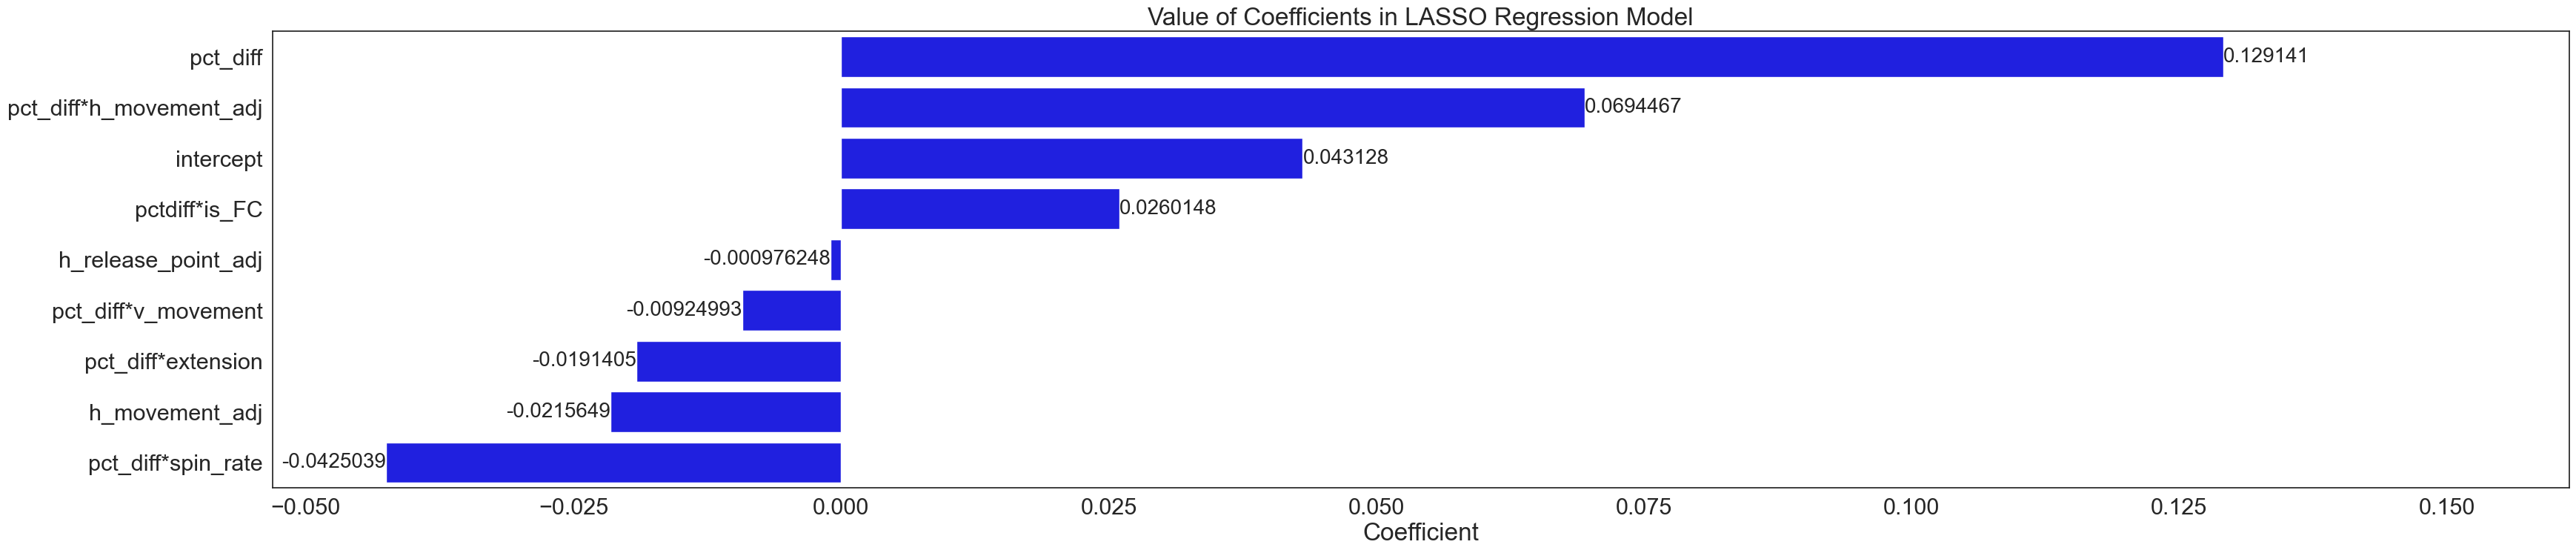

In [217]:
sns.set(font_scale=2);

# set style to whitegrid to show grid on plot
sns.set_style("white");

# create the figure and the axes
# set the figure size to 8x8
f, ax = plt.subplots(figsize=(40, 8))
# plot percentage difference and wOBA difference as scatterplot
# set point color to blue
# set transperancy to 0.5
sns.barplot(x='coefficient', y='variable', color='blue', data=coefficients_df);

ax.set_xlim(left=(1.25)*coefficients_df['coefficient'].min(), right=(1.25)*coefficients_df['coefficient'].max());

plt.title("Value of Coefficients in LASSO Regression Model");

ax.set_xlabel("Coefficient");
ax.set_ylabel("");

ax.bar_label(ax.containers[0], fontsize=20);

# f.savefig('scld_coefficients.png')

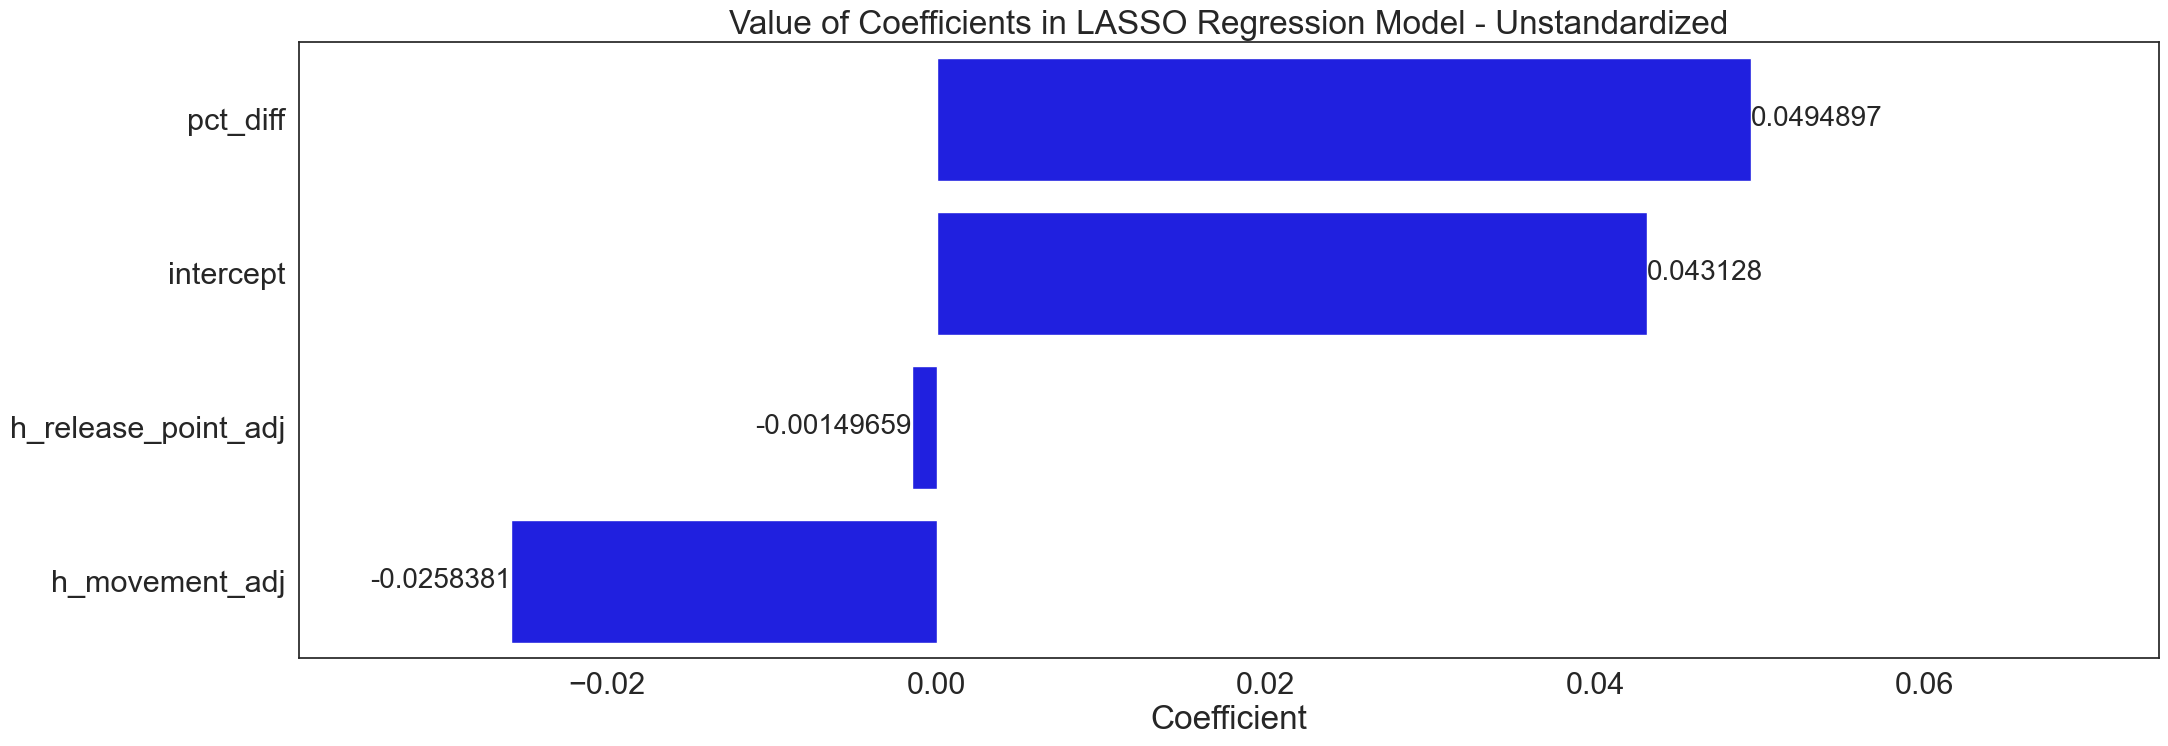

In [218]:
# set style to whitegrid to show grid on plot
sns.set_style("white");

# create the figure and the axes
# set the figure size to 8x8
f, ax = plt.subplots(figsize=(24, 8))
# plot percentage difference and wOBA difference as scatterplot
# set point color to blue
# set transperancy to 0.5
sns.barplot(x='unscld_coefficient', y='variable', color='blue', data=coefficients_df[pd.isna(coefficients_df['unscld_coefficient']) == False]);

ax.set_xlim(left=(1.5)*coefficients_df['unscld_coefficient'].min(), right=(1.5)*coefficients_df['unscld_coefficient'].max());

plt.title("Value of Coefficients in LASSO Regression Model - Unstandardized");

ax.set_xlabel("Coefficient");
ax.set_ylabel("");

ax.bar_label(ax.containers[0], fontsize=20);

# f.savefig('unscld_coefficients.png')

In [219]:
sns.set(font_scale=1);
# set style to whitegrid to show grid on plot
sns.set_style("white");

In [220]:
# model = outputs_glys1[0]
# columns = ['scld_tot_pct_diff', 
#            'is_CU', 'is_FC', 'is_FF', 'is_FS', 'is_KC', 'is_SI', 'is_SL', 'is_ST', 'is_SV',
#            'is_second', 'is_third', 'is_fourth', 'is_fifth_to_eighth',
#           'scld_tot_pitch_velocity', 'scld_tot_spin_rate', 'scld_tot_spin_angle_adj', 'scld_tot_extension',
#            'scld_tot_h_release_point_adj', 'scld_tot_v_release_point', 'scld_tot_h_movement_adj', 'scld_tot_v_movement']
# y = samples['RV_per_100_diff'].to_numpy()
    
# x_ = samples[columns].to_numpy().reshape(len(samples.index), len(columns))

# y_hat = model.predict(x_)
# residuals = np.subtract(y_hat, y)
# pct_diff_array = samples['scld_tot_pct_diff'].to_numpy()
# h_movement_adj_array = samples['scld_tot_h_movement_adj'].to_numpy()
# samples['residual'] = residuals

In [221]:
# sns.scatterplot(x='pct_diff', y='residual', color='blue', alpha=0.5, data=samples);

In [222]:
samples_test_plotting = model_samples.copy()
samples_test_plotting = samples_test_plotting.reset_index()

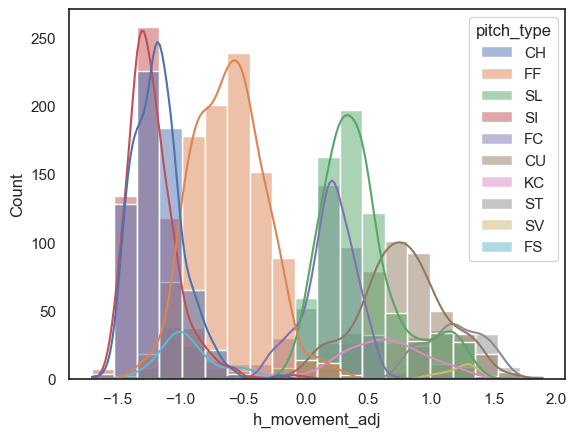

In [223]:
sns.histplot(x='h_movement_adj', hue='pitch_type', alpha=0.5, kde=True, data=samples_test_plotting);

<Axes: xlabel='spin_angle_adj', ylabel='Count'>

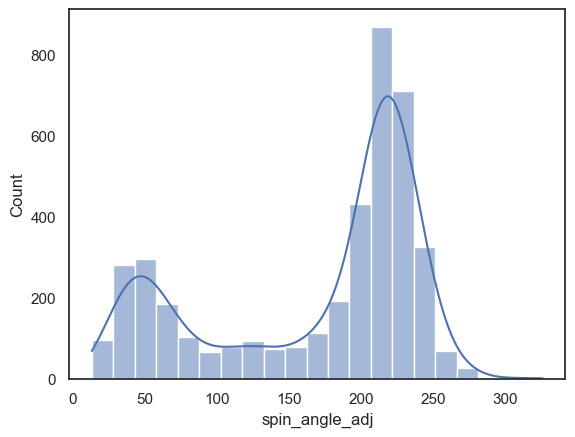

In [224]:
sns.histplot(x='spin_angle_adj', alpha=0.5, kde=True, data=samples_test_plotting)

In [225]:
h_movement_adj_stats = pitch_type_metrics.groupby('pitch_type').agg(mean_h_movement_adj=('h_movement_adj', 'mean'),
                                                                               std_h_movement_adj=('h_movement_adj', 'std'))
h_movement_adj_stats.head()

,mean_h_movement_adj,std_h_movement_adj
pitch_type,,
CH,-1.149825,0.245396
CU,0.716516,0.360095
FC,0.168843,0.236933
FF,-0.631785,0.289160
FS,-0.834810,0.340806


In [226]:
h_movement_adj_stats['left_h_movement_adj'] = h_movement_adj_stats['mean_h_movement_adj'] - h_movement_adj_stats['std_h_movement_adj']
h_movement_adj_stats['right_h_movement_adj'] = h_movement_adj_stats['mean_h_movement_adj'] + h_movement_adj_stats['std_h_movement_adj']
h_movement_adj_stats.head()

,mean_h_movement_adj,std_h_movement_adj,left_h_movement_adj,right_h_movement_adj
pitch_type,,,,
CH,-1.149825,0.245396,-1.395221,-0.904428
CU,0.716516,0.360095,0.356421,1.076611
FC,0.168843,0.236933,-0.068090,0.405776
FF,-0.631785,0.289160,-0.920945,-0.342625
FS,-0.834810,0.340806,-1.175616,-0.494003


In [227]:
model_samples['pct_diff'].describe()

count    4102.000000
mean        0.000407
std         0.026094
min        -0.205058
25%        -0.012424
50%         0.000513
75%         0.013092
max         0.165155
Name: pct_diff, dtype: float64

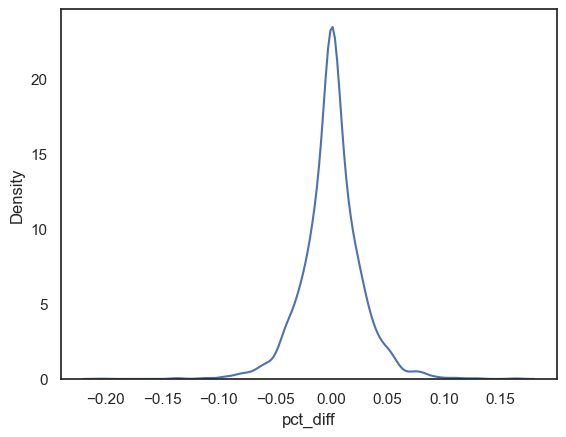

In [228]:
sns.kdeplot(x='pct_diff', bw_adjust=1, data=model_samples);

In [229]:
model_samples.index.names

FrozenList(['game_year', 'player_name', 'pitcher', 'pitch_type', 'sample_number'])

In [230]:
pitcher_seasons

num_samples
game_year player_name       pitcher             
2021      Abad, Fernando    472551             0
          Abbott, Cory      676265             0
          Abreu, Albert     656061             0
          Abreu, Bryan      650556             0
          Acevedo, Domingo  642758             0
...                                          ...
2023      Zastryzny, Rob    642239             0
          Zerpa, Angel      672582             0
          Zimmermann, Bruce 669145             0
          Zuñiga, Guillermo 670871             0
          deGrom, Jacob     594798             0

[2529 rows x 1 columns]

In [231]:
pitcher_full_seasons = pitch_pct_full_season.join(rv_full_season, how='inner')
pitcher_full_seasons

pct     use  RV_per_100
game_year player_name       pitcher pitch_type                              
2021      Abad, Fernando    472551  CH          0.157191   third    1.859574
                                    FC          0.053512   fifth   -6.031250
                                    FF          0.063545  fourth  -14.668421
                                    KC          0.260870  second   -1.183333
                                    SI          0.464883   first    2.145324
...                                                  ...     ...         ...
2023      Zuñiga, Guillermo 670871  SL          0.395349  second    0.941176
          deGrom, Jacob     594798  CH          0.088692   third    4.695000
                                    CU          0.019956  fourth    4.133333
                                    FF          0.521064   first    0.831064
                                    SL          0.370288  second    0.471257

[10322 rows x 3 columns]

In [232]:
# encode pitch types with binary identifier columns in samples DataFrame
create_binary_pitch_type_column_from_index(pitcher_full_seasons, 'CU')
create_binary_pitch_type_column_from_index(pitcher_full_seasons, 'FC')
create_binary_pitch_type_column_from_index(pitcher_full_seasons, 'FF')
create_binary_pitch_type_column_from_index(pitcher_full_seasons, 'FS')
create_binary_pitch_type_column_from_index(pitcher_full_seasons, 'KC')
create_binary_pitch_type_column_from_index(pitcher_full_seasons, 'SI')
create_binary_pitch_type_column_from_index(pitcher_full_seasons, 'SL')
create_binary_pitch_type_column_from_index(pitcher_full_seasons, 'ST')
create_binary_pitch_type_column_from_index(pitcher_full_seasons, 'SV')

In [233]:
# encode usage ranks with binary indentifier columns in samples DataFrame
create_binary_pitch_use_column(pitcher_full_seasons, 'second')
create_binary_pitch_use_column(pitcher_full_seasons, 'third')
create_binary_pitch_use_column(pitcher_full_seasons, 'fourth')
create_binary_pitch_use_column(pitcher_full_seasons, 'fifth')
create_binary_pitch_use_column(pitcher_full_seasons, 'sixth')
create_binary_pitch_use_column(pitcher_full_seasons, 'seventh')
create_binary_pitch_use_column(pitcher_full_seasons, 'eighth')

In [234]:
pitcher_full_seasons['is_fifth_to_eighth'] = (pitcher_full_seasons['is_fifth'] + pitcher_full_seasons['is_sixth'] + pitcher_full_seasons['is_seventh'] + pitcher_full_seasons['is_eighth'])

In [235]:
pitcher_full_seasons = pitcher_full_seasons.join(pitch_type_metrics, how='inner')
pitcher_full_seasons = pitcher_full_seasons[(pd.isna(pitcher_full_seasons['spin_rate']) == False) & (pd.isna(pitcher_full_seasons['spin_angle_adj']) == False)]

In [236]:
pitcher_full_seasons['std_pitch_velocity'] = (pitcher_full_seasons['pitch_velocity'] - model_samples['pitch_velocity'].mean())/model_samples['pitch_velocity'].std()
pitcher_full_seasons['std_spin_rate'] = (pitcher_full_seasons['spin_rate'] - model_samples['spin_rate'].mean())/model_samples['spin_rate'].std()
pitcher_full_seasons['std_spin_angle_adj'] = (pitcher_full_seasons['spin_angle_adj'] - model_samples['spin_angle_adj'].mean())/model_samples['spin_angle_adj'].std()
pitcher_full_seasons['std_extension'] = (pitcher_full_seasons['extension'] - model_samples['extension'].mean())/model_samples['extension'].std()
pitcher_full_seasons['std_h_release_point_adj'] = (pitcher_full_seasons['h_release_point_adj'] - model_samples['h_release_point_adj'].mean())/model_samples['h_release_point_adj'].std()
pitcher_full_seasons['std_v_release_point'] = (pitcher_full_seasons['v_release_point'] - model_samples['v_release_point'].mean())/model_samples['v_release_point'].std()
pitcher_full_seasons['std_h_movement_adj'] = (pitcher_full_seasons['h_movement_adj'] - model_samples['h_movement_adj'].mean())/model_samples['h_movement_adj'].std()
pitcher_full_seasons['std_v_movement'] = (pitcher_full_seasons['v_movement'] - model_samples['v_movement'].mean())/model_samples['v_movement'].std()

In [237]:
example_columns = ['is_CU', 'is_FC', 'is_FF', 'is_FS', 'is_KC', 'is_SI', 'is_SL', 'is_ST', 'is_SV',
           'is_second', 'is_third', 'is_fourth', 'is_fifth_to_eighth',
          'std_pitch_velocity', 'std_spin_rate', 'std_spin_angle_adj', 'std_extension',
           'std_h_release_point_adj', 'std_v_release_point', 'std_h_movement_adj', 'std_v_movement']
example_array = pitcher_full_seasons[example_columns].to_numpy().reshape(len(pitcher_full_seasons), len(example_columns))

In [238]:
example_df_cole = pitcher_full_seasons.loc[(2023, 'Cole, Gerrit', slice(None), slice(None)), :]
example_array_cole = example_df_cole[example_columns].to_numpy().reshape(len(example_df_cole.index), len(example_columns))
incr_by_5_pct_array = np.repeat(0.05, len(example_df_cole.index))
incr_by_5_pct_array = (incr_by_5_pct_array - model_samples['pct_diff'].mean()) / model_samples['pct_diff'].std()
incr_by_5_pct_array = incr_by_5_pct_array.reshape(-1, 1)
example_array_cole = np.concatenate((incr_by_5_pct_array, example_array_cole), axis=1)
example_array_cole_ = PolynomialFeatures(interaction_only=True, include_bias=False).fit_transform(example_array_cole)

In [239]:
example_df_cole['pred_RV_per_100_diff'] = model.predict(example_array_cole_)

/var/folders/8k/8dtwqkz13n7_yyj509ckx33w0000gn/T/ipykernel_26969/2656575138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_df_cole['pred_RV_per_100_diff'] = model.predict(example_array_cole_)


In [241]:
example_df_cole[['pct', 'RV_per_100', 'pred_RV_per_100_diff']]

pct  RV_per_100  \
game_year player_name  pitcher pitch_type                         
2023      Cole, Gerrit 543037  CH          0.071015    0.670386   
                               FC          0.070101    0.011739   
                               FF          0.530021    1.691604   
                               KC          0.120695    1.016667   
                               SL          0.208168    1.398829   

                                           pred_RV_per_100_diff  
game_year player_name  pitcher pitch_type                        
2023      Cole, Gerrit 543037  CH                      0.303792  
                               FC                      0.337180  
                               FF                      0.171309  
                               KC                      0.366344  
                               SL                      0.322999

In [242]:
example_df_snell = pitcher_full_seasons.loc[(2023, 'Snell, Blake', slice(None), slice(None)), :]
example_array_snell = example_df_snell[example_columns].to_numpy().reshape(len(example_df_snell.index), len(example_columns))
throw_even_pct_array = example_df_snell['pct'].to_numpy()
throw_even_pct_array = (1/len(example_df_snell.index)) - throw_even_pct_array
throw_even_pct_array = (throw_even_pct_array - model_samples['pct_diff'].mean()) / model_samples['pct_diff'].std()
throw_even_pct_array = throw_even_pct_array.reshape(-1, 1)
example_array_snell = np.concatenate((throw_even_pct_array, example_array_snell), axis=1)
example_array_snell_ = PolynomialFeatures(interaction_only=True, include_bias=False).fit_transform(example_array_snell)

In [243]:
example_df_snell['pred_RV_per_100_diff'] = model.predict(example_array_snell_)

/var/folders/8k/8dtwqkz13n7_yyj509ckx33w0000gn/T/ipykernel_26969/2314615172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_df_snell['pred_RV_per_100_diff'] = model.predict(example_array_snell_)


In [244]:
example_df_snell[['pct', 'RV_per_100', 'pred_RV_per_100_diff']]

pct  RV_per_100  \
game_year player_name  pitcher pitch_type                         
2023      Snell, Blake 605483  CH          0.184343    2.185616   
                               CU          0.197917    3.483732   
                               FF          0.486427    0.324465   
                               SL          0.131313    1.017308   

                                           pred_RV_per_100_diff  
game_year player_name  pitcher pitch_type                        
2023      Snell, Blake 605483  CH                      0.272483  
                               CU                      0.435784  
                               FF                     -0.477519  
                               SL                      0.641208

In [245]:
# predictions = model.predict(example_array)

In [246]:
pitcher_full_seasons['pred_RV_per_100_increase'] = model.predict(example_array_)

In [247]:
pitcher_full_seasons['pred_RV_per_100_increase'].min()

0.1929221309322347

In [248]:
pitcher_full_seasons.sort_values(by='pred_RV_per_100_increase', ascending=False)

pct     use  RV_per_100  \
game_year player_name      pitcher pitch_type                                 
2021      Honeywell, Brent 641703  FC          0.168831   third    0.500000   
          Spitzbarth, Shea 665661  FC          0.024390  fourth    5.050000   
2022      Castro, Kervin   665645  FC          0.071130   third   -4.076471   
          Molina, Yadier   425877  CU          0.740741   first  -17.010000   
          Rossman, Bubby   657745  FC          0.222222  second    2.275000   
...                                                 ...     ...         ...   
2021      Sadler, Casey    594987  CH          0.003442  fourth   -6.650000   
2023      Hoffman, Jeff    656546  SI          0.004603  fourth    8.700000   
2022      Williams, Devin  642207  CH          0.580524   first    1.229677   
2021      Díaz, Edwin      621242  SI          0.006006   third   -0.100000   
2023      Williams, Devin  642207  CH          0.579114   first    2.577778   

                                               is_CU  is_FC  is_FF  is_FS  \
game_year player_name      pitcher pitch_type                               
2021      Honeywell, Brent 641703  FC              0      1      0      0   
          Spitzbarth, Shea 665661  FC              0      1      0      0   
2022      Castro, Kervin   665645  FC              0      1      0      0   
          Molina, Yadier   425877  CU              1      0      0      0   
          Rossman, Bubby   657745  FC              0      1      0      0   
...                                              ...    ...    ...    ...   
2021      Sadler, Casey    594987  CH              0      0      0      0   
2023      Hoffman, Jeff    656546  SI              0      0      0      0   
2022      Williams, Devin  642207  CH              0      0      0      0   
2021      Díaz, Edwin      621242  SI              0      0      0      0   
2023      Williams, Devin  642207  CH              0      0      0      0   

                                               is_KC  is_SI  is_SL  ...  \
game_year player_name      pitcher pitch_type                       ...   
2021      Honeywell, Brent 641703  FC              0      0      0  ...   
          Spitzbarth, Shea 665661  FC              0      0      0  ...   
2022      Castro, Kervin   665645  FC              0      0      0  ...   
          Molina, Yadier   425877  CU              0      0      0  ...   
          Rossman, Bubby   657745  FC              0      0      0  ...   
...                                              ...    ...    ...  ...   
2021      Sadler, Casey    594987  CH              0      0      0  ...   
2023      Hoffman, Jeff    656546  SI              0      1      0  ...   
2022      Williams, Devin  642207  CH              0      0      0  ...   
2021      Díaz, Edwin      621242  SI              0      1      0  ...   
2023      Williams, Devin  642207  CH              0      0      0  ...   

                                               h_movement_adj  \
game_year player_name      pitcher pitch_type                   
2021      Honeywell, Brent 641703  FC                0.663077   
          Spitzbarth, Shea 665661  FC                0.745000   
2022      Castro, Kervin   665645  FC                1.059412   
          Molina, Yadier   425877  CU                1.238500   
          Rossman, Bubby   657745  FC                0.497500   
...                                                       ...   
2021      Sadler, Casey    594987  CH               -1.935000   
2023      Hoffman, Jeff    656546  SI               -1.472500   
2022      Williams, Devin  642207  CH               -1.582290   
2021      Díaz, Edwin      621242  SI               -1.656667   
2023      Williams, Devin  642207  CH               -1.651366   

                                               std_pitch_velocity  \
game_year player_name      pitcher pitch_type                       
2021      Honeywell, Brent 641703  FC                   -0.255

In [249]:
pitcher_full_seasons.groupby('pitch_type').agg(pred_RV_per_100_increase=('pred_RV_per_100_increase', 'mean'))

,pred_RV_per_100_increase
pitch_type,
CH,0.238834
CU,0.279439
FC,0.308815
FF,0.235483
FS,0.260127
KC,0.276527
SI,0.223927
SL,0.269574
ST,0.285245


In [250]:
pitcher_full_seasons.loc[(2023, 'Cole, Gerrit', slice(None), slice(None)), ['pct', 'RV_per_100', 'pred_RV_per_100_increase']]

pct  RV_per_100  \
game_year player_name  pitcher pitch_type                         
2023      Cole, Gerrit 543037  CH          0.071015    0.670386   
                               FC          0.070101    0.011739   
                               FF          0.530021    1.691604   
                               KC          0.120695    1.016667   
                               SL          0.208168    1.398829   

                                           pred_RV_per_100_increase  
game_year player_name  pitcher pitch_type                            
2023      Cole, Gerrit 543037  CH                          0.240014  
                               FC                          0.304889  
                               FF                          0.228809  
                               KC                          0.276312  
                               SL                          0.263134

In [251]:
pitcher_full_seasons.loc[(2023, 'Snell, Blake', slice(None), slice(None)), ['pct', 'RV_per_100', 'pred_RV_per_100_increase']]

pct  RV_per_100  \
game_year player_name  pitcher pitch_type                         
2023      Snell, Blake 605483  CH          0.184343    2.185616   
                               CU          0.197917    3.483732   
                               FF          0.486427    0.324465   
                               SL          0.131313    1.017308   

                                           pred_RV_per_100_increase  
game_year player_name  pitcher pitch_type                            
2023      Snell, Blake 605483  CH                          0.232567  
                               CU                          0.285797  
                               FF                          0.231710  
                               SL                          0.257087

In [252]:
# results_df = pitcher_full_seasons.sort_values(by='pred_RV_per_100_increase', ascending=False)
# results_df.head()

In [253]:
# results_df.reset_index().to_csv('PitchUseAndPerformanceResults.csv')

In [254]:
# sns.scatterplot(x='h_movement_adj', y='pred_RV_per_100_increase', alpha=0.5, data=results_df);

In [255]:
# model_samples['pct_diff'].max()

In [256]:
# model_samples['pct_diff'].min()

In [257]:
# incr_by_5_pct_array

In [258]:
# example_array

In [259]:
# model_columns = ['scld_tot_pct_diff', 
#            'is_CU', 'is_FC', 'is_FF', 'is_FS', 'is_KC', 'is_SI', 'is_SL', 'is_ST', 'is_SV',
#            'is_second', 'is_third', 'is_fourth', 'is_fifth_to_eighth',
#           'scld_tot_pitch_velocity', 'scld_tot_spin_rate', 'scld_tot_spin_angle_adj', 'scld_tot_extension',
#            'scld_tot_h_release_point_adj', 'scld_tot_v_release_point', 'scld_tot_h_movement_adj', 'scld_tot_v_movement']

In [260]:
# pitcher_full_seasons.columns